# Exploring the 2017 Data Science Bowl ( Lung Cancer Detection )

An exploration into the lung dataset.

In [46]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,6);
plt.rcParams['text.usetex'] = True;

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
INPUT_FOLDER = 'sample_images/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [2]:
# Function taken from the data_exploration kernel.
# Load the scans in given folder path
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [3]:
patient0_dicom = load_scan(os.path.join(INPUT_FOLDER, patients[0]))

In [4]:
patients[0]

'00cba091fa4ad62cc3200a657aeb957e'

In [88]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

## Training Labels

Exploration into the form of the Labels.

In [5]:
training_labels_df = pd.read_csv('./stage1_labels.csv');
training_labels_df.head()

,id,cancer
0,0015ceb851d7251b8f399e39779d1e7d,1
1,0030a160d58723ff36d73f41b170ec21,0
2,003f41c78e6acfa92430a057ac0b306e,0
3,006b96310a37b36cccb2ab48d10b49a3,1
4,008464bb8521d09a42985dd8add3d0d2,1


So we literally have a binary value associated or disassociated with cancer.  Let's see how many of each type we'll be working with.

In [6]:
bin_label = training_labels_df['cancer'].values;
total_num = len(bin_label);
print('Percentage of Cancerous Patients: {}'.format(np.sum(bin_label)/total_num));
print('Percentage of Safe Patients: {}'.format(np.sum(bin_label == 0)/total_num));
print('Total Number of Patients: {}'.format(total_num));

Percentage of Cancerous Patients: 0.25912670007158195
Percentage of Safe Patients: 0.740873299928418
Total Number of Patients: 1397


### Cancer vs. Cancer Free Patients in sample dataset

In [7]:
training_labels = training_labels_df.values;

sample_labels = {row[0]:row[1] for row in filter(lambda patid: patid[0] in patients, training_labels)};
sampleids, labels = zip(*list(sample_labels.items()))

cancerids = [iD for iD in sampleids if sample_labels[iD]]
freeids = [iD for iD in sampleids if not sample_labels[iD]]

print('Cancerous IDs')
print('\n'.join(cancerids))
print()
print('Cancer Free IDs')
print('\n'.join(freeids))

Cancerous IDs
0c37613214faddf8701ca41e6d43f56e
0c0de3749d4fe175b7a5098b060982a1
0d06d764d3c07572074d468b4cff954f
0acbebb8d463b4b9ca88cf38431aac69
0c60f4b87afcb3e2dfa65abbbf3ef2f9

Cancer Free IDs
0c59313f52304e25d5a7dcf9877633b1
0de72529c30fe642bc60dcb75c87f6bd
0ddeb08e9c97227853422bd71a2a695e
00cba091fa4ad62cc3200a657aeb957e
0ca943d821204ceb089510f836a367fd
0c9d8314f9c69840e25febabb1229fa4
0d2fcf787026fece4e57be167d079383
0a0c32c9e08cc2ea76a71649de56be6d
0a38e7597ca26f9374f8ea2770ba870d
0d19f1c627df49eb223771c28548350e
0d941a3ad6c889ac451caf89c46cb92a
0a099f2549429d29b32f349e95fb2244
0c98fcb55e3f36d0c2b6507f62f4c5f1
0bd0e3056cbf23a1cb7f0f0b18446068


## Exploring Lung Segmentation

We've got to reduce our data size somehow, so we'll look into some primitive segmentation techniques.

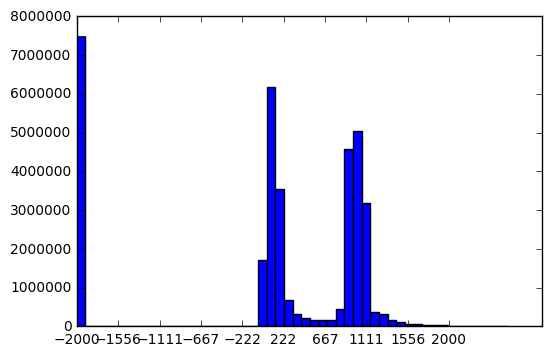

In [16]:
patient0_pixels = np.array([dic.pixel_array for dic in patient0_dicom]);

fig = plt.figure();
ax = fig.gca();
ax.hist(patient0_pixels.flatten(), bins=50);
ax.set_xticks(np.linspace(-2000,2000,10))
plt.show();

In [111]:
from skimage import segmentation
from matplotlib import gridspec
from scipy.ndimage.filters import gaussian_filter

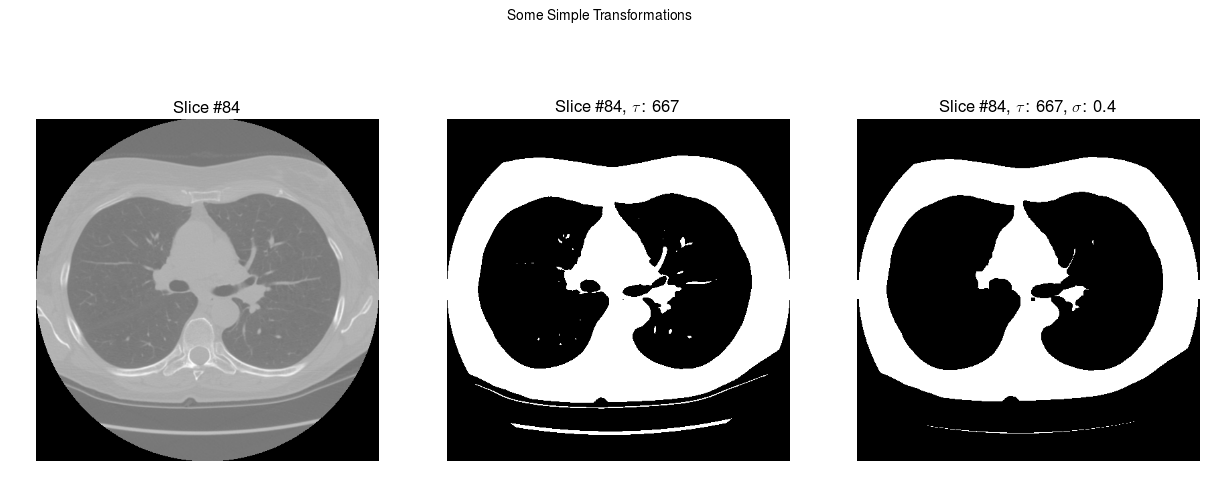

In [123]:
# ax1
slice_number = 84;
slic = patient0_pixels[slice_number];

#ax2
thresh = 667;
thresh_slic = slic > thresh;

#ax3
filter_sigma = 0.4;
filtered_slice = gaussian_filter(thresh_slic, sigma=filter_sigma);

#   create figure
fig = plt.figure(figsize=(15,6));
gs = gridspec.GridSpec(nrows=1, ncols=3);

ax1 = plt.subplot(gs[0,0]);
ax1.imshow(slic, cmap='gray');
ax1.set_title('Slice \\#{}'.format(slice_number));
ax1.axis('off');

ax2 = plt.subplot(gs[0,1]);
ax2.imshow(thresh_slic, cmap='gray');
ax2.set_title('Slice \\#{}, $\\tau$: {}'.format(slice_number, thresh));
ax2.axis('off');

ax2 = plt.subplot(gs[0,2]);
ax2.imshow(filtered_slice, cmap='gray');
ax2.set_title('Slice \\#{}, $\\tau$: {}, $\\sigma$: {}'.format(slice_number, thresh, filter_sigma));
ax2.axis('off');

fig.suptitle('Some Simple Transformations');

plt.show();

### Clear Border Segmentation

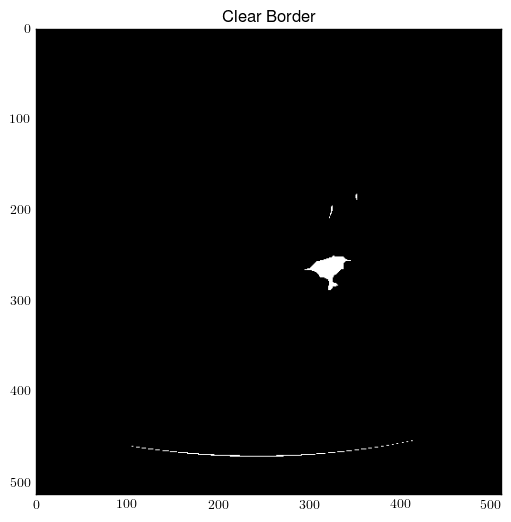

In [126]:
slic_clearborder = segmentation.clear_border(filtered_slice);
plt.imshow(slic_clearborder, cmap='gray');
plt.title('Clear Border');

### Felzsenzwalb

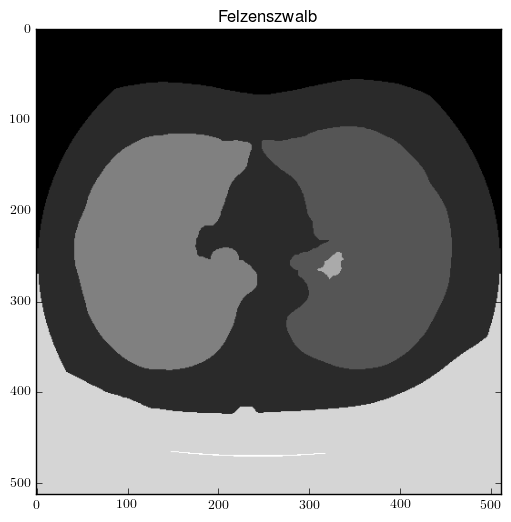

In [118]:
felz_slic = segmentation.felzenszwalb(filtered_slice, scale=1.5, sigma=0.1);
plt.imshow(felz_slic, cmap='gray');
plt.title('Felzenszwalb');

### K-Means -- Couldn't get to work :(

In [89]:
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

l = 100
x, y = np.indices((l, l))

center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)
radius1, radius2, radius3, radius4 = 16, 14, 15, 14

circle1 = (x - center1[0])**2 + (y - center1[1])**2 < radius1**2
circle2 = (x - center2[0])**2 + (y - center2[1])**2 < radius2**2
circle3 = (x - center3[0])**2 + (y - center3[1])**2 < radius3**2
circle4 = (x - center4[0])**2 + (y - center4[1])**2 < radius4**2

# 4 circles
img = circle1 + circle2 + circle3 + circle4
mask = img.astype(bool)
img = img.astype(float)

img += 1 + 0.2*np.random.randn(*img.shape)
# Convert the image into a graph with the value of the gradient on
# the edges.
graph = image.img_to_graph(img, mask=mask)

# Take a decreasing function of the gradient: we take it weakly
# dependant from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-graph.data/graph.data.std())

labels = spectral_clustering(graph, n_clusters=4, eigen_solver='arpack')
label_im = -np.ones(mask.shape)
label_im[mask] = labels

In [96]:
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering, k_means

In [102]:
slice_mask = thresh_slic.astype('bool');
slice_as_graph = image.img_to_graph(filtered_slice.astype('float'), mask=slice_mask);

slice_as_graph.data = np.exp(-slice_as_graph.data/slice_as_graph.data.std());

#slice_labels = spectral_clustering(slice_as_graph, n_clusters=2, eigen_solver='arpack');
#spec_clustered_slice = -np.ones(slice_mask.shape);
#spec_clustered_slice[slice_mask] = slice_labels;

#plt.imshow(spec_clustered_slice);

## Marker Based Segmentation



In [142]:
from skimage import measure, morphology
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from scipy import ndimage

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ..., 
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

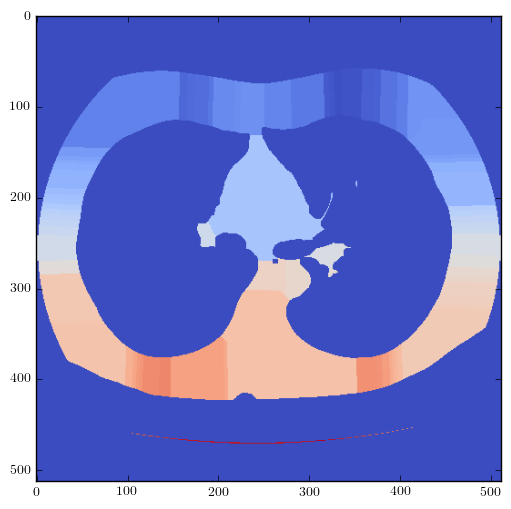

In [163]:
dt_filtered_slice = ndimage.distance_transform_edt(filtered_slice);
max_filt = peak_local_max(dt_filtered_slice, indices=False, footprint=np.ones((10, 10)), labels=filtered_slice);
markers = morphology.label(max_filt);
labels_ws = watershed(-dt_filtered_slice, markers, mask=filtered_slice);

plt.imshow(labels_ws, cmap='coolwarm');

## Measurements

Connected Components Found: 31


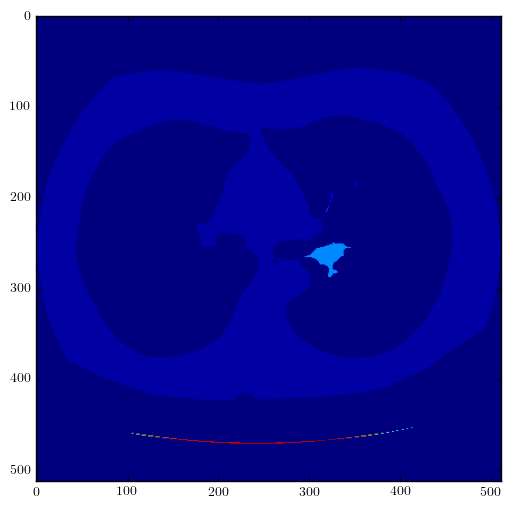

In [180]:
label_im, nb_labels = ndimage.label(filtered_slice);
print('Connected Components Found: {}'.format(nb_labels));

sizes = ndimage.sum(filtered_slice, label_im, range(nb_labels + 1))
mean_vals = ndimage.sum(slic, label_im, range(1, nb_labels + 1))

plt.imshow(label_im);

In [181]:
print(np.min(label_im))

0


### Mean HU Values / Sizes of Above Labelings

In [189]:
for data in zip(range(nb_labels), sizes, mean_vals):
    print('Comp: {:2}, Size: {:8}, Mean HU: {:10}'.format(*data));

Comp:  0, Size:      0.0, Mean HU: 86546203.0
Comp:  1, Size:  82342.0, Mean HU:    10554.0
Comp:  2, Size:     11.0, Mean HU:    16700.0
Comp:  3, Size:     17.0, Mean HU:     1956.0
Comp:  4, Size:      2.0, Mean HU:     1950.0
Comp:  5, Size:      2.0, Mean HU:     2022.0
Comp:  6, Size:      2.0, Mean HU:     2060.0
Comp:  7, Size:      2.0, Mean HU:   755686.0
Comp:  8, Size:    724.0, Mean HU:     2350.0
Comp:  9, Size:      2.0, Mean HU:     2374.0
Comp: 10, Size:      2.0, Mean HU:     2476.0
Comp: 11, Size:      2.0, Mean HU:     2447.0
Comp: 12, Size:      2.0, Mean HU:     2537.0
Comp: 13, Size:      2.0, Mean HU:     3758.0
Comp: 14, Size:      3.0, Mean HU:     2619.0
Comp: 15, Size:      2.0, Mean HU:     3707.0
Comp: 16, Size:      3.0, Mean HU:     5208.0
Comp: 17, Size:      4.0, Mean HU:     5042.0
Comp: 18, Size:      4.0, Mean HU:     6506.0
Comp: 19, Size:      5.0, Mean HU:     5005.0
Comp: 20, Size:      4.0, Mean HU:     7791.0
Comp: 21, Size:      6.0, Mean HU:

### Filter out components

In [201]:
upperlimit_size = 5000;
lowerlimit_size = 200;

valid_labels = filter(lambda tup: (tup[1] < upperlimit_size and tup[1] > lowerlimit_size),
                      zip(range(nb_labels), sizes)
                     );

print(list(valid_labels));

[(8, 724.0)]


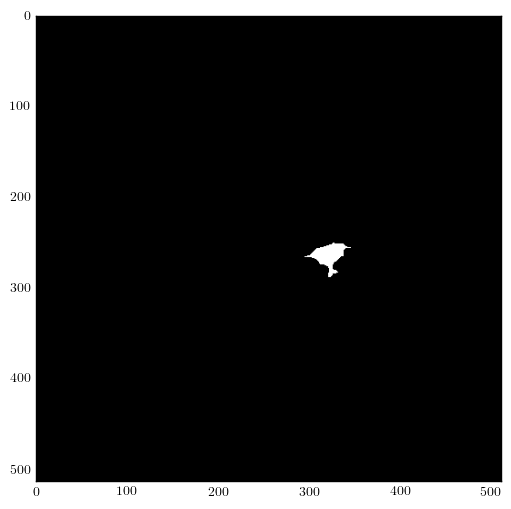

In [196]:
plt.imshow(label_im == 8, cmap='gray');

## Let's get a close up :)

Size of ROI: (38, 51)


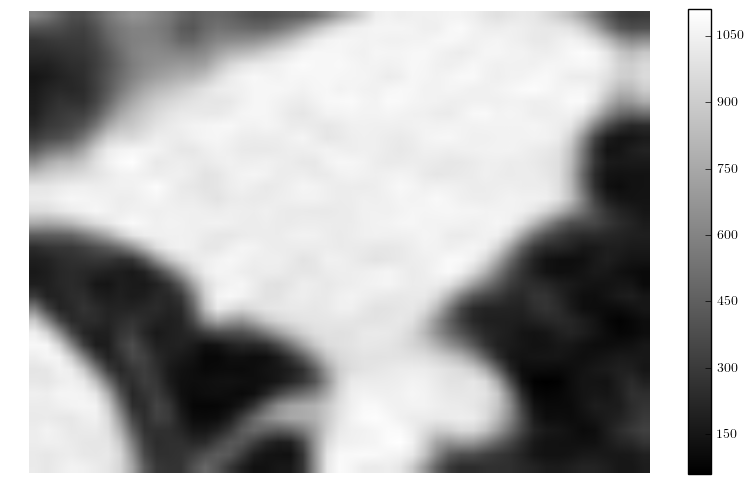

In [202]:
slice_x, slice_y = ndimage.find_objects(label_im==8)[0];
roi = slic[slice_x, slice_y];
print('Size of ROI: {}'.format(roi.shape))
plt.imshow(roi, cmap='gray');
plt.axis('off')
plt.colorbar();

### Links to much better segmentation stuff

* [Scipy Lecture on Image Processing](http://www.scipy-lectures.org/advanced/image_processing/#segmentation)
* [Skimage Lecture on Image Processing](http://www.scipy-lectures.org/packages/scikit-image/#image-segmentation)